# ostu tresholding

In [62]:
import cv2
import numpy as np
import os
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def load_yolo_annotations(annotation_file, image):
    bboxes = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            # only extract x_center, y_center, width, height
            x_center, y_center, width, height = map(float, parts[1:5])
            # normalized axis to absolute pixel axis
            img_width, img_height = image.shape[1], image.shape[0]
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_width)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_width)
            bboxes.append([x_min, y_min, x_max, y_max])
    return bboxes

def read_json(json_file):
    with open(json_file, 'r') as file:
        return json.load(file)
    
def extract_patches(image, bboxes):
    patches = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        patch = image[y_min:y_max, x_min:x_max]
        patch = Image.fromarray(patch)
        patches.append(patch)
    return patches


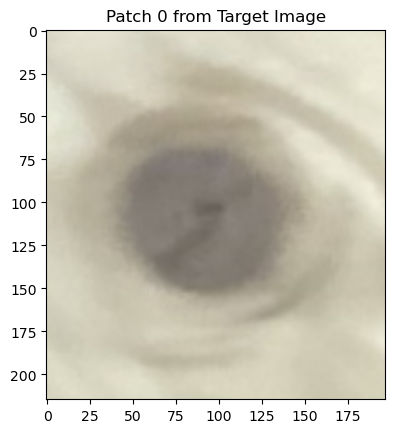

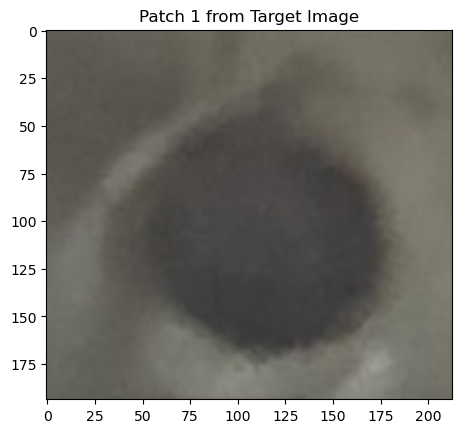

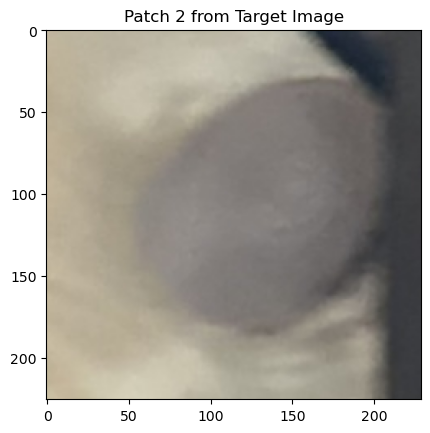

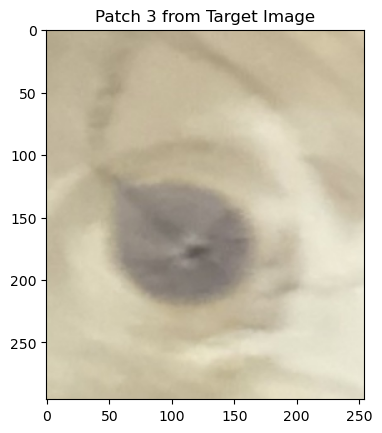

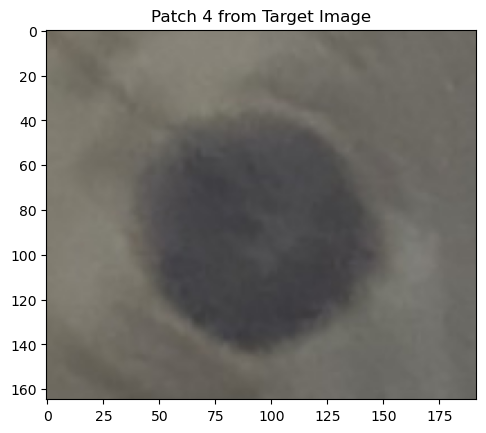

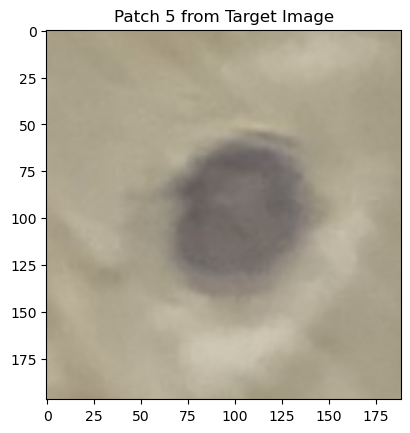

In [63]:
#! image with 6 knots
target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M1_0244.jpeg'
target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M1_0244.json'

# #! image with metal
# target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M2_0082.jpeg'
# target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M2_0082.json'


target_bboxes = []
target_patches = []
   
# read image and json
image = cv2.imread(target_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = Image.fromarray(image)


json_data = read_json(target_json)

# extract bboxes
for box in json_data['boxes']:
    coordinates = (box['x1'], box['y1'], box['x2'], box['y2'])
    target_bboxes.append(coordinates)
    
# extract patches and features
patches = extract_patches(image, target_bboxes)
target_patches.extend(patches)

if target_patches:
    num_patches_to_show = min(10, len(target_patches))
    for index in range(num_patches_to_show):
        patch = target_patches[index]
        
        plt.imshow(patch)
        plt.title(f"Patch {index} from Target Image")
        plt.show()


In [64]:
def apply_otsu_threshold(patch):
    # Convert patch to grayscale
    gray_patch = patch.convert('L')
    gray_np = np.array(gray_patch)

    # Apply Otsu's threshold
    _, otsu_thresh = cv2.threshold(gray_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    #! Invert the threshold result(white background)
    otsu_thresh = cv2.bitwise_not(otsu_thresh)

    
    # Display the Otsu threshold result
    plt.imshow(otsu_thresh, cmap='gray')
    plt.title("Otsu Threshold Result")
    plt.show()
    
    return otsu_thresh

def find_largest_contour(otsu_thresh):
    # Find contours to get the new bounding box
    contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours found: {len(contours)}")
    
    if contours:
        # Find the largest contour by area
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        return x, y, w, h
    
    return None

def adjust_bbox_and_extract_patch(patch, bbox, contour_bbox):
    if contour_bbox:
        x, y, w, h = contour_bbox

        # Adjust bbox relative to the original bbox
        new_x_min = bbox[0] + x
        new_y_min = bbox[1] + y
        new_x_max = new_x_min + w
        new_y_max = new_y_min + h

        # Update bbox
        new_bbox = [new_x_min, new_y_min, new_x_max, new_y_max]

        # Extract the new patch
        new_patch = patch.crop((x, y, x + w, y + h))
        
        return new_patch, new_bbox

    return patch, bbox

def process_patch_with_otsu(patch, bbox):
    # Step 1: Apply Otsu threshold using the provided function
    otsu_thresh = apply_otsu_threshold(patch)

    # Step 2: Find the largest contour and get the bounding box
    contour_bbox = find_largest_contour(otsu_thresh)

    # Step 3: Adjust the bbox and extract the new patch
    new_patch, new_bbox = adjust_bbox_and_extract_patch(patch, bbox, contour_bbox)
    
    return new_patch, new_bbox

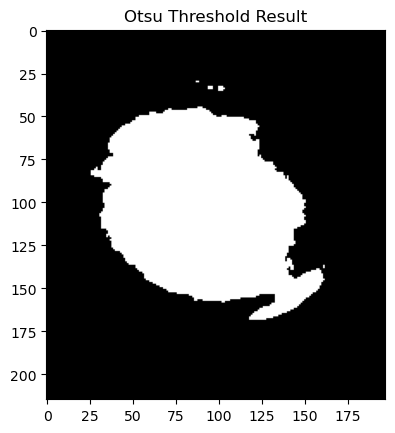

Number of contours found: 5


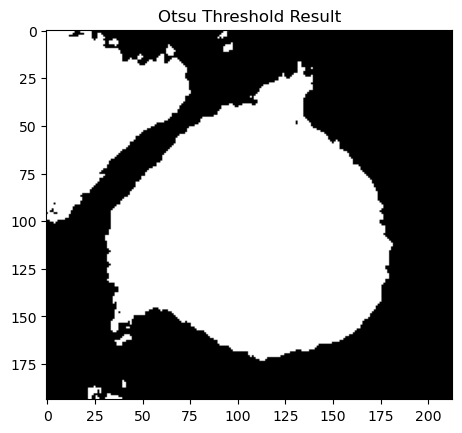

Number of contours found: 14


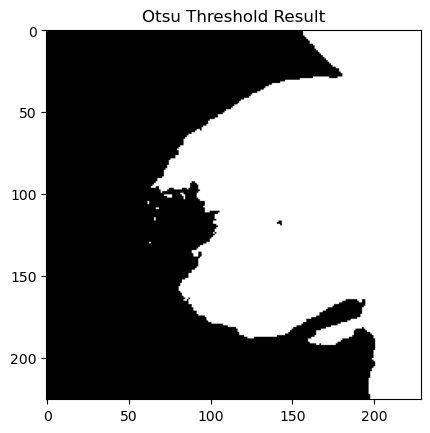

Number of contours found: 7


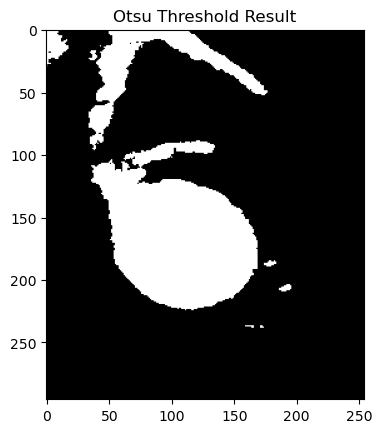

Number of contours found: 9


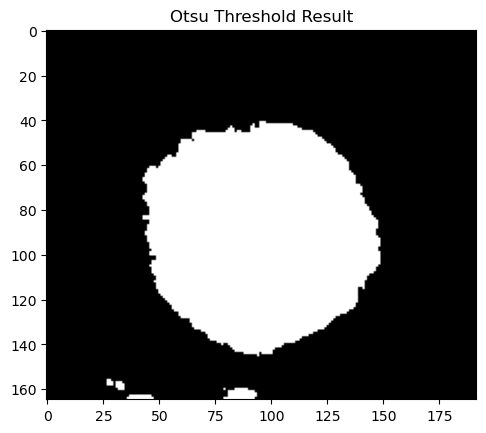

Number of contours found: 6


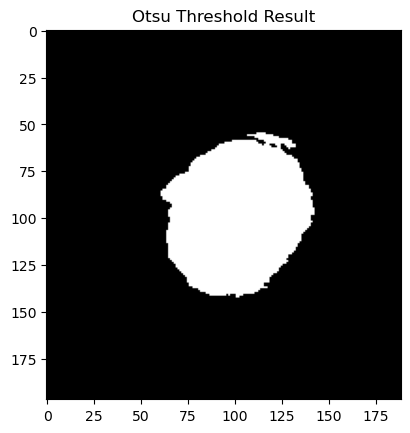

Number of contours found: 1


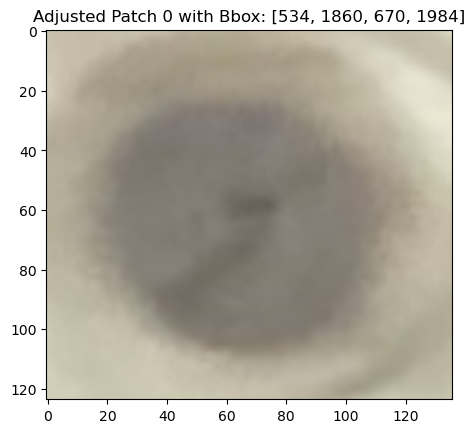

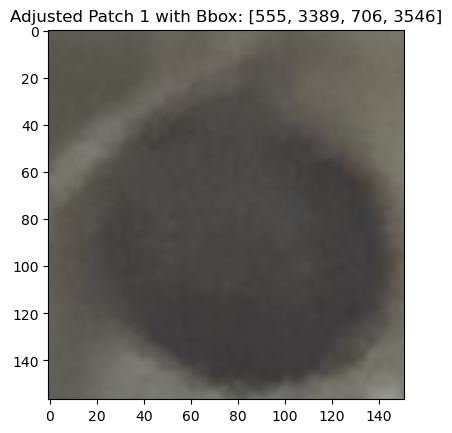

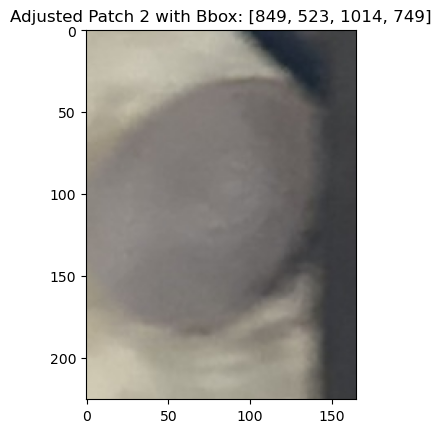

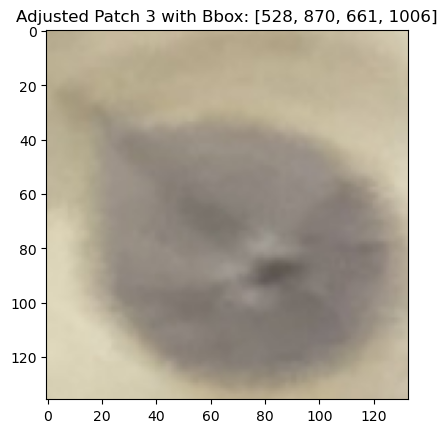

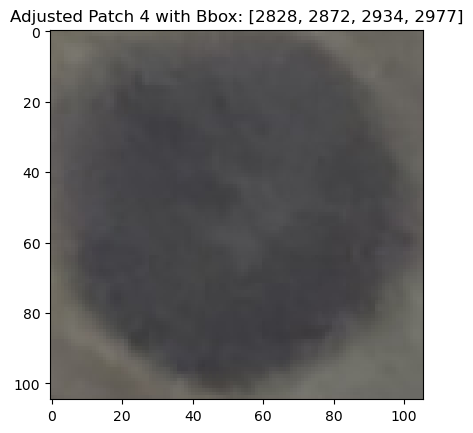

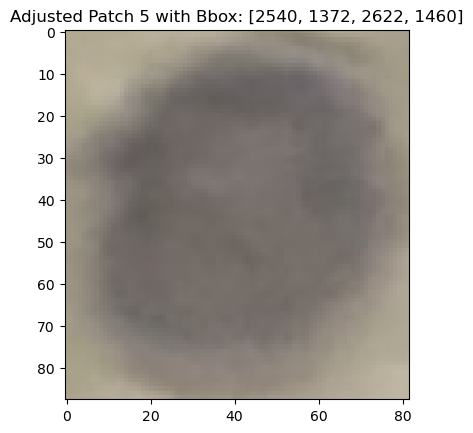

Patch 0: Adjusted Bbox: [534, 1860, 670, 1984]
Patch 1: Adjusted Bbox: [555, 3389, 706, 3546]
Patch 2: Adjusted Bbox: [849, 523, 1014, 749]
Patch 3: Adjusted Bbox: [528, 870, 661, 1006]
Patch 4: Adjusted Bbox: [2828, 2872, 2934, 2977]
Patch 5: Adjusted Bbox: [2540, 1372, 2622, 1460]


In [65]:

adjusted_patches = []
adjusted_bboxes = []

for patch, bbox in zip(target_patches, target_bboxes):
    new_patch, new_bbox = process_patch_with_otsu(patch, bbox)
    adjusted_patches.append(new_patch)
    adjusted_bboxes.append(new_bbox)
    
# Display results
if adjusted_patches:
    num_patches_to_show = min(10, len(adjusted_patches))
    for index in range(num_patches_to_show):
        patch = adjusted_patches[index]
        
        # Display the adjusted patch
        plt.imshow(patch)
        plt.title(f"Adjusted Patch {index} with Bbox: {adjusted_bboxes[index]}")
        plt.show()

# Output adjusted patches and bboxes
for i, (patch, bbox) in enumerate(zip(adjusted_patches, adjusted_bboxes)):
    print(f"Patch {i}: Adjusted Bbox: {bbox}")


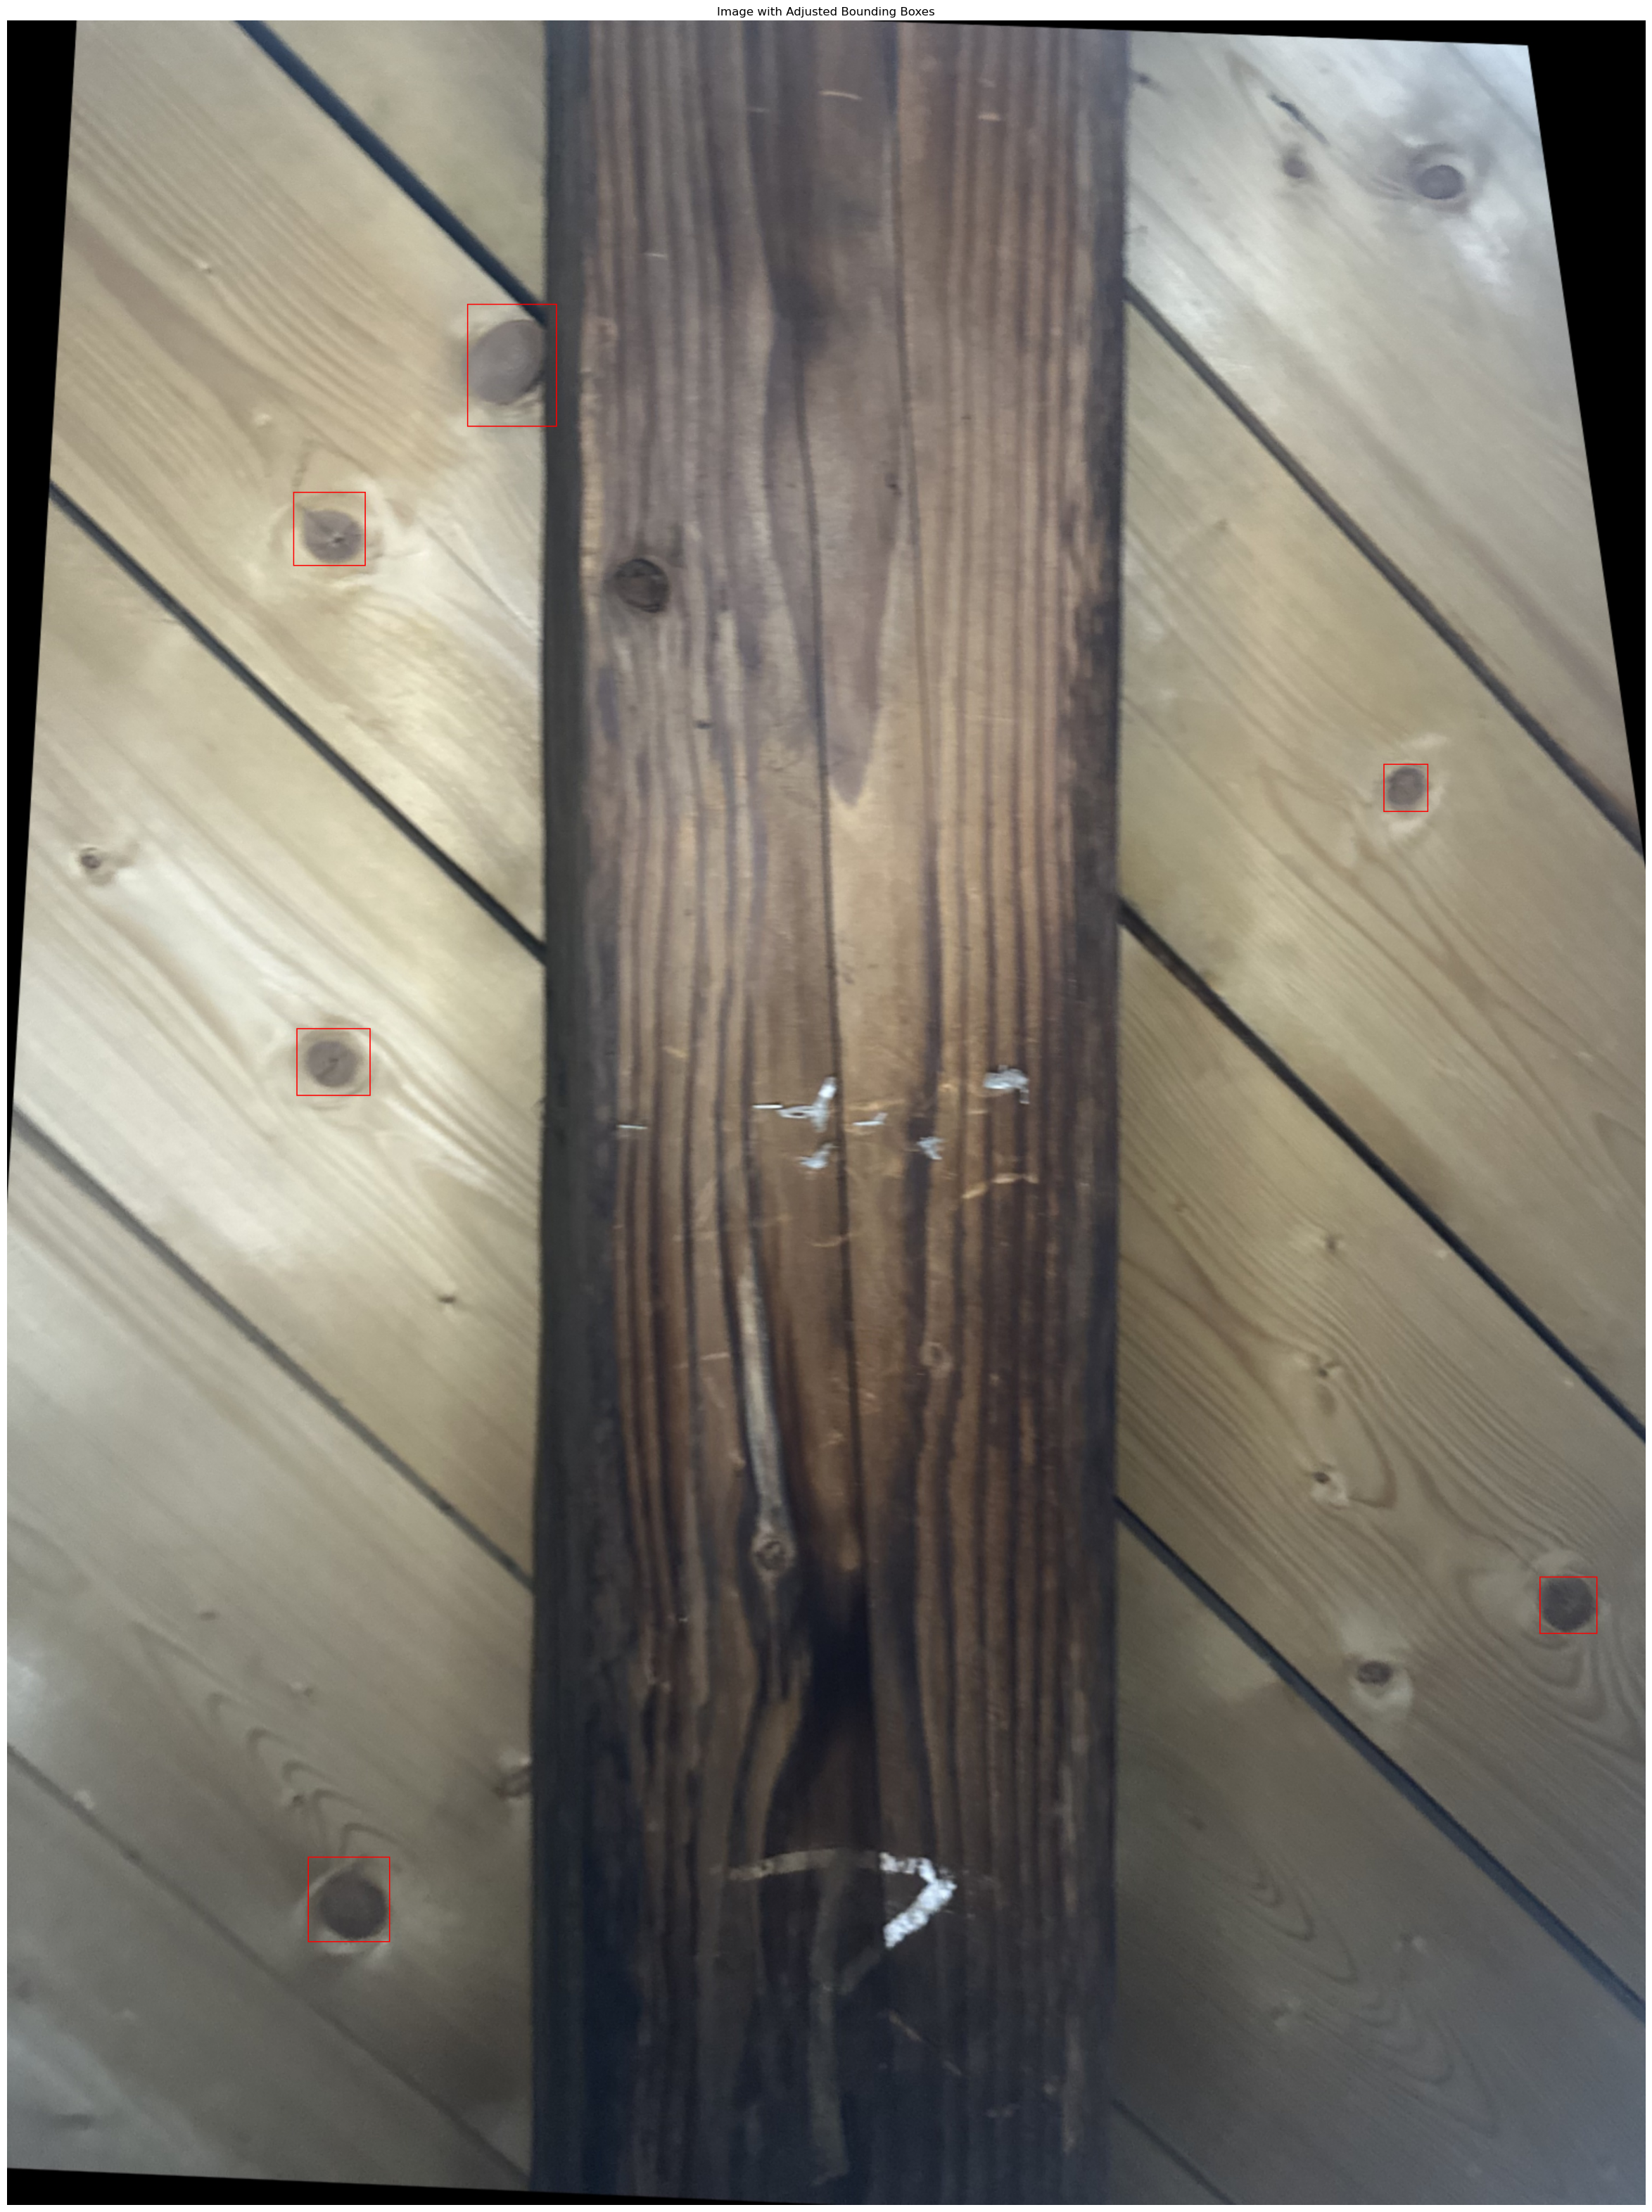

In [66]:
def draw_bboxes_on_image(original_image, bboxes):
    image_copy = original_image.copy()
    
    draw = ImageDraw.Draw(image_copy)

    for bbox in bboxes:
        draw.rectangle(bbox, outline="red", width=2)

    width, height = image_copy.size

    plt.figure(figsize=(width / 100, height / 100), dpi=100)
    
    plt.imshow(image_copy)
    plt.axis('off') 
    plt.title("Image with Adjusted Bounding Boxes")
    plt.show()

    return image_copy

result_image = draw_bboxes_on_image(original_image, adjusted_bboxes)
